## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Тояков |
|---------|--------|
| Группа  | 407    |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

Теперь загружаем датасет:

In [4]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [5]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [6]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [8]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size=20
n_classes=10
dataset = torch.utils.data.TensorDataset(torch.tensor(X_train,dtype=torch.float32),torch.tensor(y_train,dtype=torch.long))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size)
val_x = torch.tensor(X_train,dtype=torch.float32, device=device)
val_lab = torch.tensor(y_train, device=device)
dataset_tst = torch.utils.data.TensorDataset(torch.tensor(X_test,dtype=torch.float32),torch.tensor(y_test,dtype=torch.long))
dataloader_tst = torch.utils.data.DataLoader(dataset_tst,batch_size=batch_size)
test_x = torch.tensor(X_test,dtype=torch.float32, device=device)
test_lab = torch.tensor(y_test, device=device)

Определяем функцию тренировки и расчета точности

In [9]:
def train(net, dataloader, val_x, val_lab, epochs=10, lr=0.0005):
    optim = torch.optim.Adam(net.parameters(),lr=lr)
    l_dots = []
    ac_dots = []
    for ep in range(epochs):
        for (x,y) in dataloader:               
            z = net(x.to(device))
            loss = torch.nn.functional.cross_entropy(z,y.to(device))
            optim.zero_grad()
            loss.backward()
            optim.step()
        acc = get_acc(net, dataloader, val_x, val_lab)
        l_dots.append(loss)
        ac_dots.append(acc)
        print(f"Epoch {ep}: last batch loss = {loss}, val acc = {acc}")
    plt.plot(l_dots)
    plt.title("loss")
    plt.show()
    plt.plot(ac_dots)
    plt.title("accuracy")
    plt.show()
        
def get_acc(net, dataloader, val_x, val_lab):
    acc = ((torch.max(net(val_x),1)[1]).to(device) == val_lab).float().mean()
    return acc

Строим однослойный персептрон и тренируем его

Epoch 0: last batch loss = 7.49661111831665, val acc = 0.6798507571220398
Epoch 1: last batch loss = 6.086737155914307, val acc = 0.785216748714447
Epoch 2: last batch loss = 5.4319047927856445, val acc = 0.8227789402008057
Epoch 3: last batch loss = 4.710494041442871, val acc = 0.8445984125137329
Epoch 4: last batch loss = 4.34873104095459, val acc = 0.8564676642417908
Epoch 5: last batch loss = 3.852673292160034, val acc = 0.8643568158149719
Epoch 6: last batch loss = 3.62715482711792, val acc = 0.8700782060623169
Epoch 7: last batch loss = 3.2964115142822266, val acc = 0.8755152821540833
Epoch 8: last batch loss = 3.0117883682250977, val acc = 0.8796730637550354
Epoch 9: last batch loss = 2.7664756774902344, val acc = 0.8831556439399719


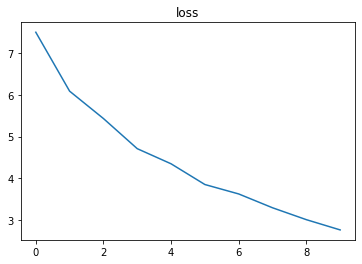

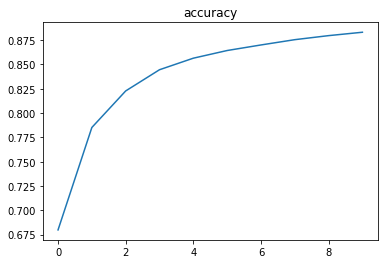

In [10]:
net = torch.nn.Linear(X_train.shape[1],10).to(device)
train(net,dataloader,val_x,val_lab,lr=0.00002)

Матрица ошибок

In [11]:
from sklearn.metrics import confusion_matrix
y_pred = torch.max(net(val_x),1)[1].cpu()
confusion_matrix(y_train, y_pred.numpy())

array([[2638,    0,   20,   15,    3,   36,   33,   15,   32,    7],
       [   0, 3007,   31,   31,    7,   13,    4,   19,   44,    8],
       [  15,   36, 2375,   68,   48,   12,   56,   53,   82,   18],
       [  14,   19,   87, 2477,    5,  102,   18,   27,   93,   38],
       [   6,   11,   13,    8, 2484,    6,   22,   21,   28,  115],
       [  37,   18,   21,  130,   43, 2013,   78,   17,  202,   31],
       [  12,    6,   26,    6,   29,   24, 2613,    1,   21,    2],
       [  10,   13,   37,   16,   27,    6,    3, 2690,   15,  104],
       [  20,   59,   56,  124,   37,  108,   33,   22, 2200,   70],
       [  10,   15,    7,   45,  159,   21,    4,  177,   47, 2355]])

Результат для тестовой выборки

In [12]:
acc = get_acc(net, dataloader_tst, test_x, test_lab)
print(f"accuracy = {acc}")

accuracy = 0.8753968477249146


Опеределим класс для двухслойного персептрона

In [13]:
class MyNet(torch.nn.Module):
    def __init__(self,hidden_size=50,func=torch.nn.Sigmoid()):
        super().__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1],hidden_size).to(device)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_size, n_classes).to(device)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        return x

Создадим и обучим его

Epoch 0: last batch loss = 0.8657234907150269, val acc = 0.8385927677154541
Epoch 1: last batch loss = 0.4994331896305084, val acc = 0.8832978010177612
Epoch 2: last batch loss = 0.4320457875728607, val acc = 0.9001066088676453
Epoch 3: last batch loss = 0.38119256496429443, val acc = 0.9062899947166443
Epoch 4: last batch loss = 0.3935754895210266, val acc = 0.9137881994247437
Epoch 5: last batch loss = 0.2745627760887146, val acc = 0.9187633395195007
Epoch 6: last batch loss = 0.2548374831676483, val acc = 0.9240582585334778
Epoch 7: last batch loss = 0.37748467922210693, val acc = 0.9283937215805054
Epoch 8: last batch loss = 0.24494203925132751, val acc = 0.932409405708313
Epoch 9: last batch loss = 0.25346964597702026, val acc = 0.934470534324646


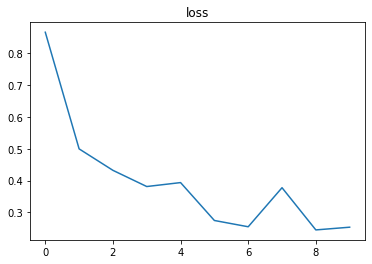

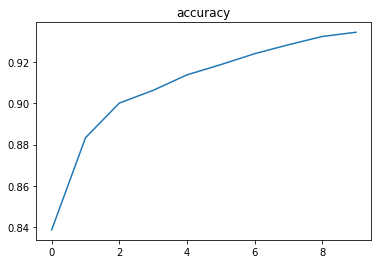

In [14]:
net = MyNet()
train(net,dataloader,val_x,val_lab,lr=0.0001)

Матрица ошибок

In [15]:
y_pred = torch.max(net(val_x),1)[1].cpu()
confusion_matrix(y_train, y_pred.numpy())

array([[2725,    0,    5,    5,   10,   17,   11,    3,   19,    4],
       [   1, 3079,   17,   13,    6,   11,    2,   11,   23,    1],
       [  22,    7, 2545,   29,   34,    6,   23,   41,   49,    7],
       [   6,    6,   69, 2621,    2,   71,    9,   34,   44,   18],
       [   5,    5,   13,    0, 2563,    3,    5,    5,   12,  103],
       [  22,    6,    9,   93,   29, 2337,   27,    5,   39,   23],
       [  26,    7,   17,    0,   26,   35, 2616,    1,   12,    0],
       [  10,   14,   22,    7,   11,    3,    3, 2802,    2,   47],
       [  15,   32,   42,   51,   18,   79,    9,   17, 2444,   22],
       [  12,    4,    3,   36,   95,   15,    1,   93,   17, 2564]])

Результат для тестовой выборки

In [16]:
acc = get_acc(net, dataloader_tst, test_x, test_lab)
print(f"accuracy = {acc}")

accuracy = 0.9200577139854431


Сравним показатели точности для разных передаточных функций

1) sigmoid

Epoch 0: last batch loss = 0.5249574780464172, val acc = 0.875373125076294
Epoch 1: last batch loss = 0.30406421422958374, val acc = 0.9028429388999939
Epoch 2: last batch loss = 0.2225179374217987, val acc = 0.9168087840080261
Epoch 3: last batch loss = 0.21695443987846375, val acc = 0.9276119470596313
Epoch 4: last batch loss = 0.1778782308101654, val acc = 0.9332267045974731
Epoch 5: last batch loss = 0.17004933953285217, val acc = 0.9372423887252808
Epoch 6: last batch loss = 0.2010786086320877, val acc = 0.9407960176467896
Epoch 7: last batch loss = 0.15996523201465607, val acc = 0.9456645250320435
Epoch 8: last batch loss = 0.1391599476337433, val acc = 0.9462686777114868
Epoch 9: last batch loss = 0.0877494066953659, val acc = 0.9519900679588318


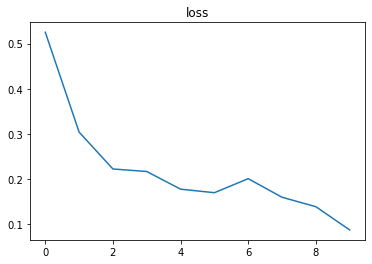

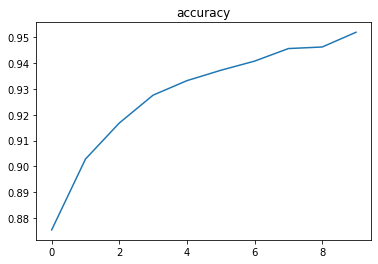

In [17]:
net = torch.nn.Sequential(torch.nn.Linear(X_train.shape[1],100),torch.nn.Sigmoid(),torch.nn.Linear(100, n_classes)).to(device)
train(net,dataloader,val_x,val_lab,lr=0.0001)

2) Softmax

Epoch 0: last batch loss = 2.1136043071746826, val acc = 0.6227079033851624
Epoch 1: last batch loss = 1.9631417989730835, val acc = 0.681201159954071
Epoch 2: last batch loss = 1.8286514282226562, val acc = 0.7073560953140259
Epoch 3: last batch loss = 1.643560767173767, val acc = 0.719687283039093
Epoch 4: last batch loss = 1.4568043947219849, val acc = 0.7180525660514832
Epoch 5: last batch loss = 1.3828805685043335, val acc = 0.7234541773796082
Epoch 6: last batch loss = 1.435142993927002, val acc = 0.7310945391654968
Epoch 7: last batch loss = 1.1822110414505005, val acc = 0.7353588938713074
Epoch 8: last batch loss = 1.1000192165374756, val acc = 0.7336176037788391
Epoch 9: last batch loss = 1.0293452739715576, val acc = 0.7358208894729614


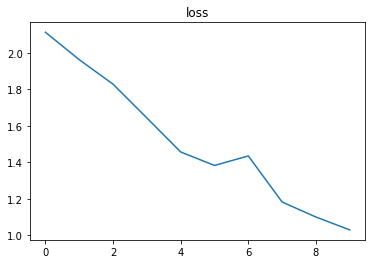

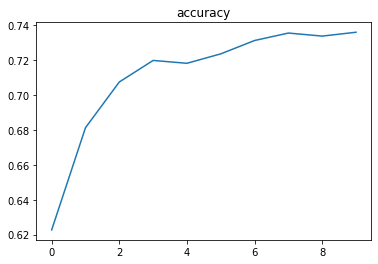

In [18]:
net = torch.nn.Sequential(torch.nn.Linear(X_train.shape[1],100),torch.nn.Softmax(dim=1),torch.nn.Linear(100, n_classes)).to(device)
train(net,dataloader,val_x,val_lab,lr=0.0001)

3) ReLU

Epoch 0: last batch loss = 0.5164154171943665, val acc = 0.877825140953064
Epoch 1: last batch loss = 0.3403152823448181, val acc = 0.9036602973937988
Epoch 2: last batch loss = 0.2672423720359802, val acc = 0.9191187024116516
Epoch 3: last batch loss = 0.22797587513923645, val acc = 0.9256218671798706
Epoch 4: last batch loss = 0.20522907376289368, val acc = 0.9316986203193665
Epoch 5: last batch loss = 0.24768562614917755, val acc = 0.9357143044471741
Epoch 6: last batch loss = 0.16800810396671295, val acc = 0.9403340220451355
Epoch 7: last batch loss = 0.1762145459651947, val acc = 0.9437100291252136
Epoch 8: last batch loss = 0.1558423638343811, val acc = 0.9464463591575623
Epoch 9: last batch loss = 0.1341705024242401, val acc = 0.9487917423248291


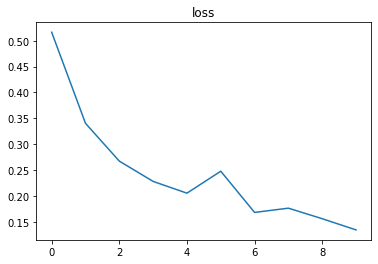

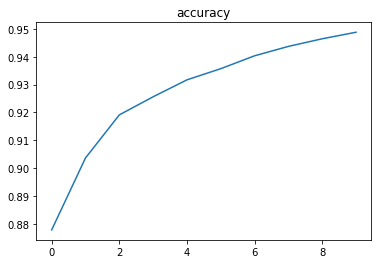

In [19]:
net = torch.nn.Sequential(torch.nn.Linear(X_train.shape[1],100),torch.nn.Sigmoid(),torch.nn.Linear(100, n_classes)).to(device)
train(net,dataloader,val_x,val_lab,lr=0.0001)

Результаты у ReLU и Sigmoid явно лучше чем у Softmax